Initial Data Head:
         date  category                              menu  quantity  \
0  2024-05-24    Others                            Siomai         2   
1  2024-05-24  Sandwich           Egg Sandwich + Coleslaw         1   
2  2024-05-24  Sandwich                 Burger + Coleslaw         1   
3  2024-05-24  Sandwich             Ham Sandwich With Egg         1   
4  2024-05-24  Sandwich  Cheeseburger With Egg + Coleslaw         1   

   total price payment      mode  
0           20    Cash  Physical  
1           30    Cash  Physical  
2           25    Cash  Physical  
3           40    Cash  Physical  
4           47    Cash  Physical  

Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10082 entries, 0 to 10081
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         10082 non-null  object
 1   category     10082 non-null  object
 2   menu         10082 non-null  object
 3   quanti

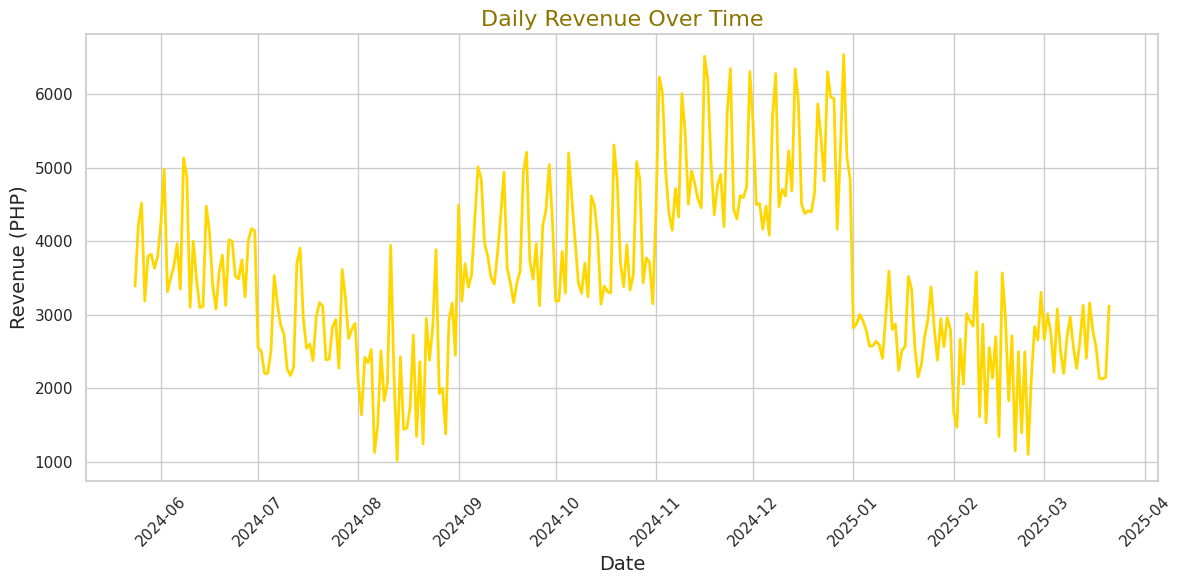

<ipython-input-6-e332fa9f2d0e>:185: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='date', y='weekly_revenue', data=weekly_revenue, palette="YlOrBr")


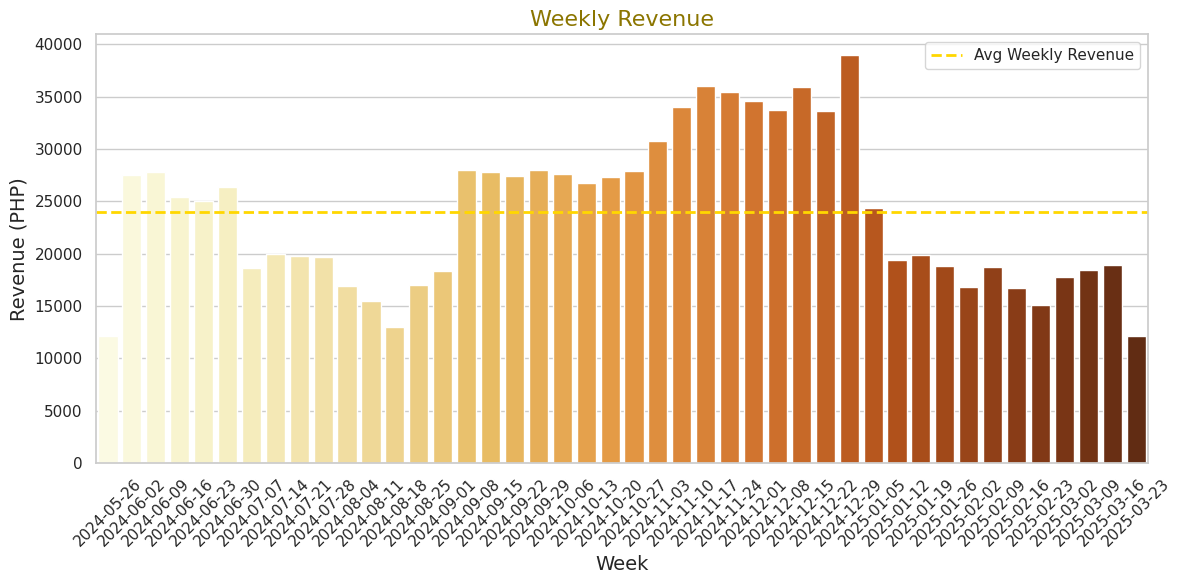

<ipython-input-6-e332fa9f2d0e>:197: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_of_week', y='total price', data=day_of_week_sales, palette="YlOrBr")


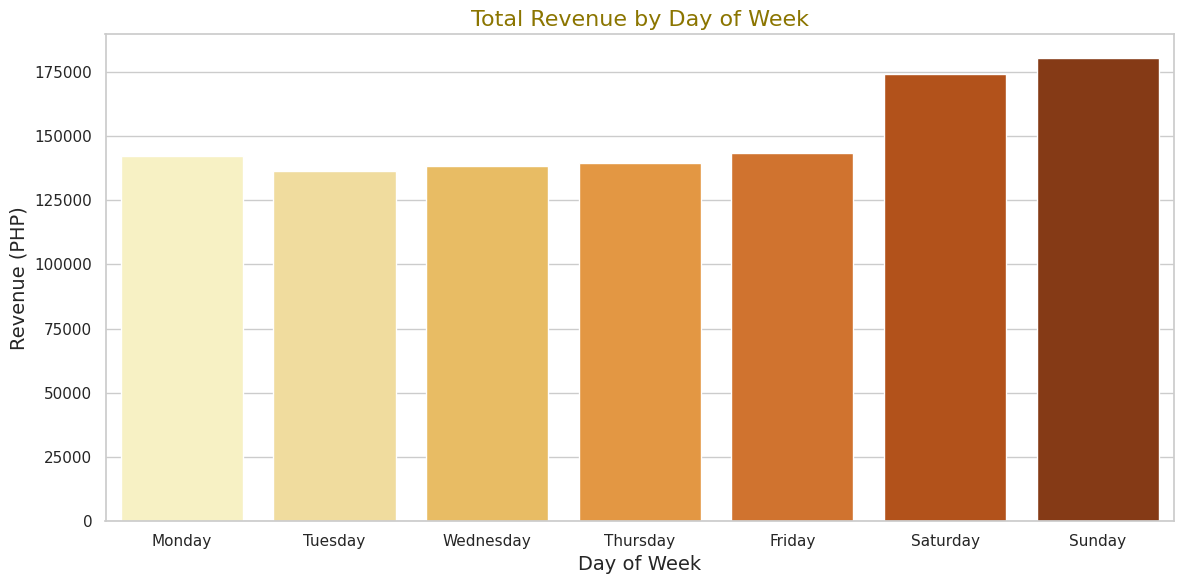

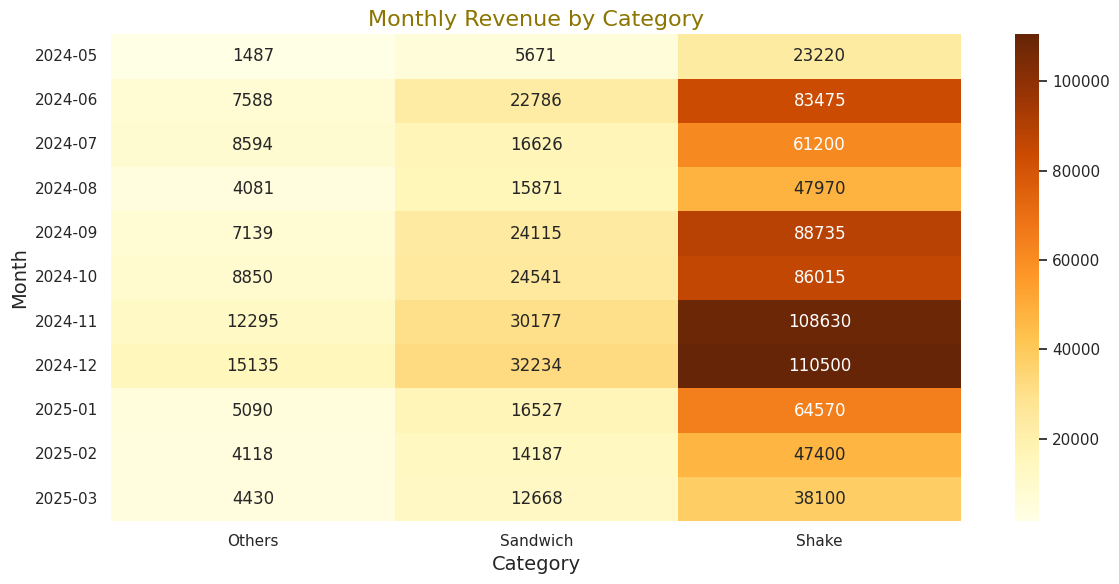

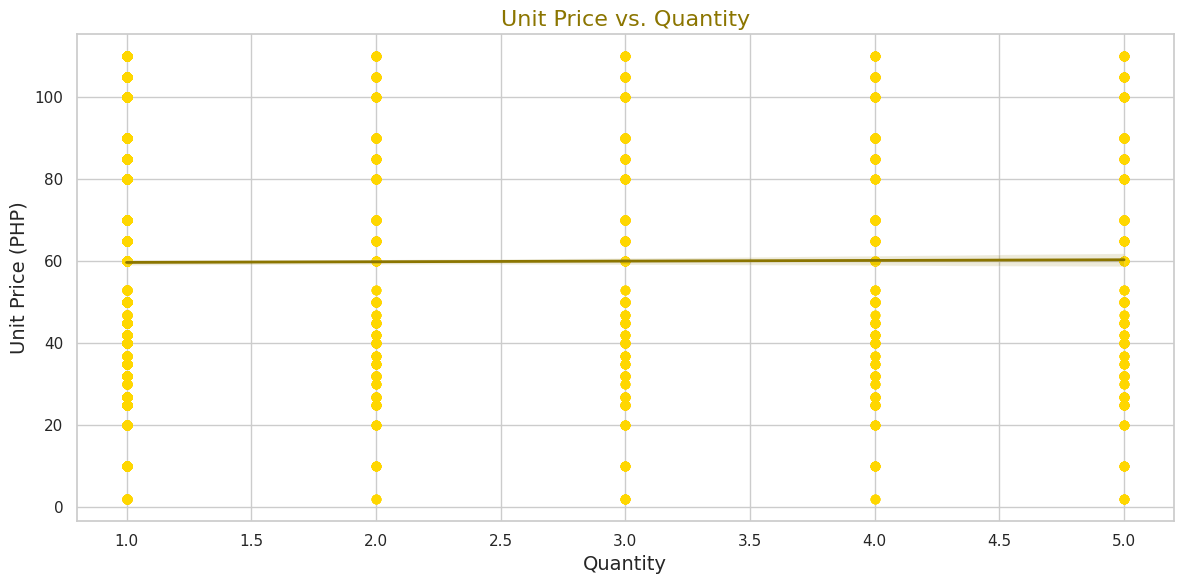

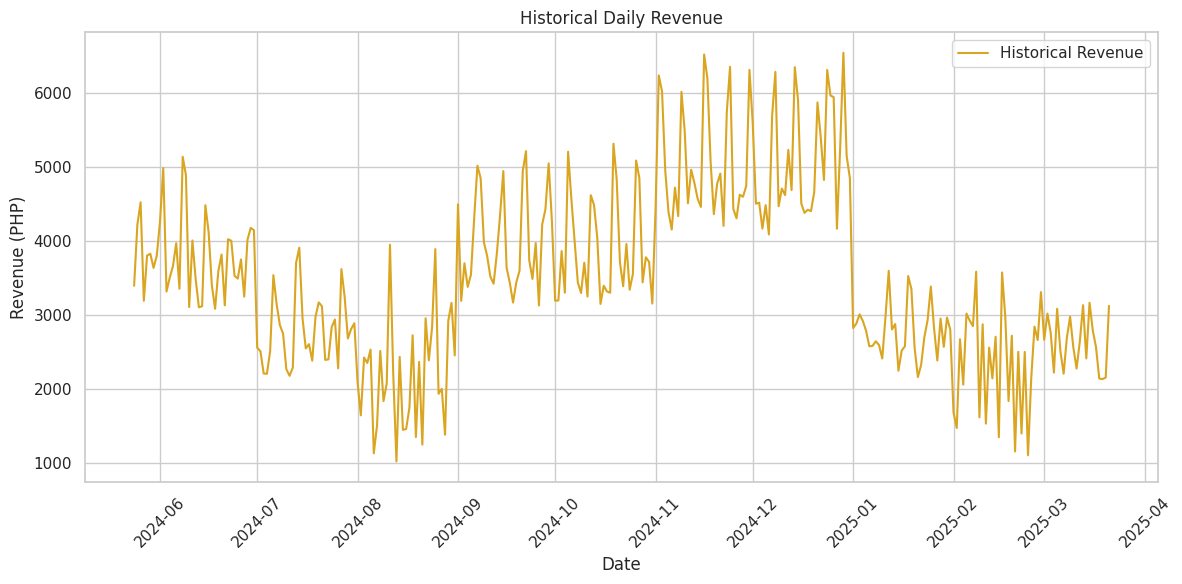

XGBoost Training RMSE: 87.54


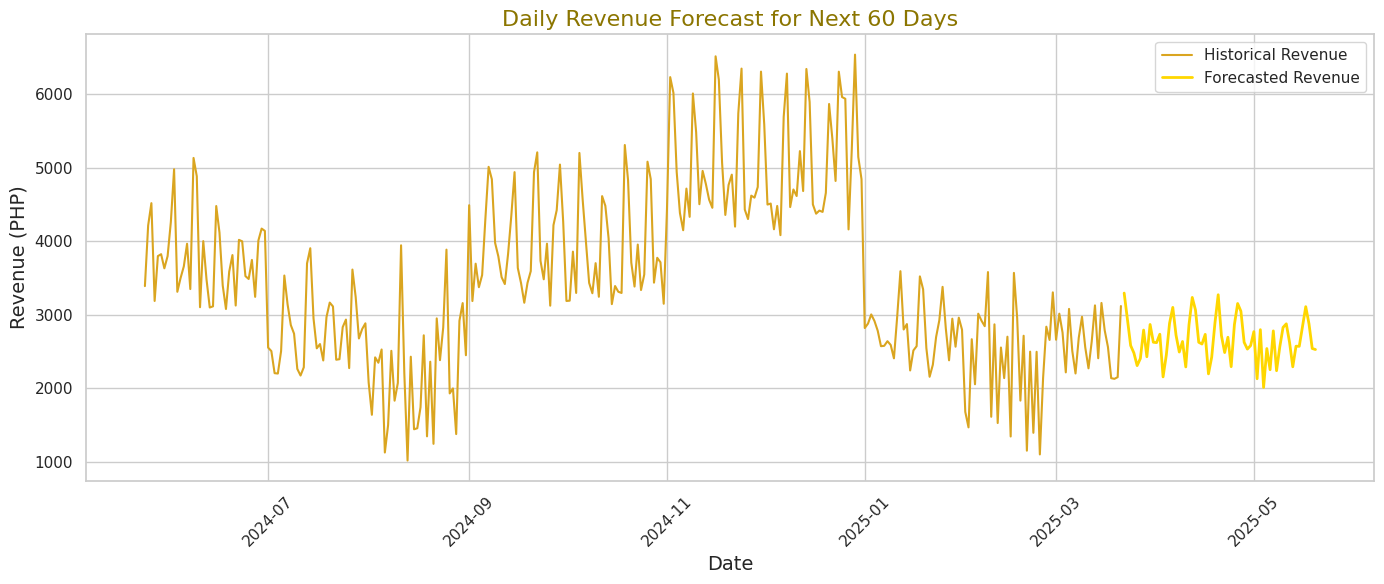

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import random

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

df = pd.read_csv("juls_burgers_sales_new.csv")
print("Initial Data Head:")
print(df.head())
print("\nInitial Data Info:")
print(df.info())

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])
df = df.sort_values("date").reset_index(drop=True)

def clean_text(text):
    """
    Strips extra whitespace, normalizes spaces, and fixes some common typos.
    """
    if pd.isnull(text):
        return text
    text = text.strip()
    text = " ".join(text.split())
    replacements = {
        "burge": "burger",
        "sandwch": "sandwich",
        "gcash": "Gcash"
    }
    text_lower = text.lower()
    for wrong, right in replacements.items():
        text_lower = text_lower.replace(wrong, right)
    return text_lower

categorical_columns = ['category', 'menu', 'payment', 'mode']
for col in categorical_columns:
    df[col] = df[col].astype(str).apply(clean_text)

def standardize_category(cat):
    """
    Map various misspellings to standard category names.
    Expected outputs: "Sandwich", "Shake", or "Others".
    """
    if pd.isnull(cat):
        return cat
    cat_lower = cat.lower().strip()
    sandwich_variants = [
        "asnwich", "asndwich", "sadnwich", "sandwch", "sandwich",
        "sandwichm", "sandwihc", "sandiwch", "sandwcih", "sanwdich",
        "sanwdichm", "snadwich", "sadwich"
    ]
    shake_variants = ["hsake", "sahke", "shaek", "shkae", "shake"]
    others_variants = ["ohters", "otehrs", "othesr", "othres", "othees", "tohers", "others"]
    for variant in sandwich_variants:
        if variant in cat_lower:
            return "Sandwich"
    for variant in shake_variants:
        if variant in cat_lower:
            return "Shake"
    for variant in others_variants:
        if variant in cat_lower:
            return "Others"
    return cat.title()

df['category'] = df['category'].apply(standardize_category)
df['menu'] = df['menu'].apply(lambda x: x.title())
df['payment'] = df['payment'].apply(lambda x: "Gcash" if "gcash" in x.lower() else "Cash")
df['mode'] = df['mode'].apply(lambda x: "Delivered" if "deliver" in x.lower() else "Physical")

df['quantity'] = pd.to_numeric(df['quantity'], errors='coerce')
df['total price'] = pd.to_numeric(df['total price'], errors='coerce')
df = df.dropna(subset=['quantity', 'total price'])
df['quantity'] = df['quantity'].astype(int)

df['unit_price'] = df['total price'] / df['quantity']
df = df[(df['unit_price'] >= 2) & (df['unit_price'] <= 200)]

print("\nCleaned Data Head:")
print(df.head())
print("\nCleaned Data Info:")
print(df.info())

clean_file_path = "juls_burgers_sales_cleaned.csv"
df.to_csv(clean_file_path, index=False)
print(f"\nCleaned CSV file saved to: {clean_file_path}")

df['day_of_week'] = df['date'].dt.day_name()
df['week_number'] = df['date'].dt.isocalendar().week
df['month'] = df['date'].dt.to_period('M').astype(str)

item_revenue = df.groupby(['category', 'menu']).agg({
    'total price': 'sum',
    'quantity': 'sum'
}).reset_index()

highest_revenue_per_category = (item_revenue.sort_values(['category', 'total price'], ascending=[True, False])
                                .groupby('category').first().reset_index())
print("\nHighest Seller by Revenue per Category:")
print(highest_revenue_per_category)

highest_quantity_per_category = (item_revenue.sort_values(['category', 'quantity'], ascending=[True, False])
                                 .groupby('category').first().reset_index())
print("\nHighest Seller by Quantity per Category:")
print(highest_quantity_per_category)

weekly_revenue = df.groupby(pd.Grouper(key='date', freq='W'))['total price'].sum().reset_index()
weekly_revenue.rename(columns={'total price': 'weekly_revenue'}, inplace=True)
avg_weekly_sales = weekly_revenue['weekly_revenue'].mean()
print("\nAverage Weekly Sales (Revenue): PHP {:.2f}".format(avg_weekly_sales))

daily_summary = df.groupby('date').agg({
    'total price': 'sum',
    'menu': 'count'
}).rename(columns={'menu': 'order_count'}).reset_index()
print("\nDaily Sales Summary (First 5 Days):")
print(daily_summary.head())

day_of_week_sales = df.groupby('day_of_week')['total price'].sum().reset_index()
order_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_of_week_sales['day_of_week'] = pd.Categorical(day_of_week_sales['day_of_week'], categories=order_days, ordered=True)
day_of_week_sales = day_of_week_sales.sort_values('day_of_week')
print("\nSales by Day of Week:")
print(day_of_week_sales)

monthly_pivot = df.pivot_table(values='total price', index='month', columns='category', aggfunc='sum', fill_value=0)
print("\nMonthly Revenue by Category:")
print(monthly_pivot)

correlation = df[['unit_price', 'quantity']].corr()
print("\nCorrelation between Unit Price and Quantity:")
print(correlation)

sns.set_palette("YlOrBr")
custom_line_color = "#FFD700"

plt.figure()
sns.lineplot(x='date', y='total price', data=daily_summary, color=custom_line_color, linewidth=2)
plt.title("Daily Revenue Over Time", fontsize=16, color="#8B7500")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Revenue (PHP)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure()
sns.barplot(x='date', y='weekly_revenue', data=weekly_revenue, palette="YlOrBr")
plt.axhline(avg_weekly_sales, color=custom_line_color, linestyle='--', linewidth=2, label="Avg Weekly Revenue")
plt.title("Weekly Revenue", fontsize=16, color="#8B7500")
plt.xlabel("Week", fontsize=14)
plt.ylabel("Revenue (PHP)", fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
sns.barplot(x='day_of_week', y='total price', data=day_of_week_sales, palette="YlOrBr")
plt.title("Total Revenue by Day of Week", fontsize=16, color="#8B7500")
plt.xlabel("Day of Week", fontsize=14)
plt.ylabel("Revenue (PHP)", fontsize=14)
plt.tight_layout()
plt.show()

plt.figure()
sns.heatmap(monthly_pivot, annot=True, fmt=".0f", cmap="YlOrBr")
plt.title("Monthly Revenue by Category", fontsize=16, color="#8B7500")
plt.xlabel("Category", fontsize=14)
plt.ylabel("Month", fontsize=14)
plt.tight_layout()
plt.show()

plt.figure()
sns.regplot(x='quantity', y='unit_price', data=df,
            scatter_kws={'alpha':0.6, 'color':"#FFD700"},
            line_kws={'color':"#8B7500", 'linewidth':2})
plt.title("Unit Price vs. Quantity", fontsize=16, color="#8B7500")
plt.xlabel("Quantity", fontsize=14)
plt.ylabel("Unit Price (PHP)", fontsize=14)
plt.tight_layout()
plt.show()

daily_rev = df.groupby('date')['total price'].sum().reset_index()
daily_rev = daily_rev.sort_values('date').reset_index(drop=True)

plt.figure(figsize=(12,6))
plt.plot(daily_rev['date'], daily_rev['total price'], label='Historical Revenue', color='goldenrod')
plt.title("Historical Daily Revenue")
plt.xlabel("Date")
plt.ylabel("Revenue (PHP)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

def create_features(df, lags=[1,2,3,7]):
    df_feat = df.copy()
    df_feat['day_of_week'] = df_feat['date'].dt.dayofweek
    df_feat['month'] = df_feat['date'].dt.month
    for lag in lags:
        df_feat[f'lag_{lag}'] = df_feat['total price'].shift(lag)
    df_feat['rolling_7'] = df_feat['total price'].rolling(window=7).mean().shift(1)
    return df_feat

data_feat = create_features(daily_rev)
data_feat = data_feat.dropna().reset_index(drop=True)
features = [col for col in data_feat.columns if col not in ['date', 'total price']]

X_train = data_feat[features]
y_train = data_feat['total price']

model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             max_depth=5,
                             learning_rate=0.1,
                             random_state=42)
model_xgb.fit(X_train, y_train)
pred_train = model_xgb.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, pred_train))
print("XGBoost Training RMSE: {:.2f}".format(rmse))

forecast_days = 60
last_date = daily_rev['date'].max()
future_dates = [last_date + timedelta(days=i+1) for i in range(forecast_days)]

history = daily_rev.copy().reset_index(drop=True)
forecasts = []

def generate_features(history, new_date, lags=[1,2,3,7]):
    new_feat = {}
    new_feat['date'] = new_date
    new_feat['day_of_week'] = new_date.dayofweek
    new_feat['month'] = new_date.month
    for lag in lags:
        if len(history) >= lag:
            new_feat[f'lag_{lag}'] = history['total price'].iloc[-lag]
        else:
            new_feat[f'lag_{lag}'] = np.nan
    if len(history) >= 7:
        new_feat['rolling_7'] = history['total price'].tail(7).mean()
    else:
        new_feat['rolling_7'] = np.nan
    return pd.DataFrame([new_feat])

for new_date in future_dates:
    new_features = generate_features(history, new_date)
    new_features = new_features.ffill()
    X_new = new_features[features]
    pred = model_xgb.predict(X_new)[0]
    forecasts.append(pred)
    new_row = pd.DataFrame({'date': [new_date], 'total price': [pred]})
    history = pd.concat([history, new_row], ignore_index=True)

forecast_df = pd.DataFrame({'date': future_dates, 'forecasted_revenue': forecasts})

plt.figure(figsize=(14,6))
plt.plot(daily_rev['date'], daily_rev['total price'], label='Historical Revenue', color='goldenrod')
plt.plot(forecast_df['date'], forecast_df['forecasted_revenue'], label='Forecasted Revenue', color=custom_line_color, linewidth=2)
plt.title("Daily Revenue Forecast for Next 60 Days", fontsize=16, color="#8B7500")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Revenue (PHP)", fontsize=14)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
